In [2]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy
from pyts.classification import TimeSeriesForest
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from pyts.multivariate.classification import MultivariateClassifier
from pyts.classification import KNeighborsClassifier
from pyts.classification import BOSSVS
from pyts.classification import TSBF
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.transformations.panel.compose import ColumnConcatenator
from sklearn.pipeline import Pipeline
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier

In [3]:
AU_COLS = ['AU01_r',
'AU02_r',
'AU04_r',
'AU05_r',
'AU06_r',
'AU07_r',
'AU09_r',
'AU10_r',
'AU12_r',
'AU14_r',
'AU15_r',
'AU17_r',
'AU20_r',
'AU23_r',
'AU25_r',
'AU26_r',
'AU45_r']

ID_COLS = ['filename', "frame", "video_id", "emotion_1_id"]

In [4]:
load_dotenv()

# path to save figures
output_path = os.getenv("VIDEO_OUT")

In [5]:
load_path = os.path.join(output_path, 'video_data_time_series_reduced.csv')
df = pd.read_csv(load_path)

In [6]:
df

,filename,frame,video_id,emotion_1_id,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,A220_reg_p_2,1,A220,0,0.000,0.0,0.420,0.0,0.0,0.137778,...,0.244,0.000000,0.328,0.000,0.119816,0.0,0.168950,0.080,0.120690,0.000000
1,A220_reg_p_2,2,A220,0,0.000,0.0,0.422,0.0,0.0,0.057778,...,0.202,0.000000,0.344,0.030,0.066820,0.0,0.146119,0.082,0.106322,0.020080
2,A220_reg_p_2,3,A220,0,0.000,0.0,0.412,0.0,0.0,0.024444,...,0.176,0.000000,0.348,0.030,0.046083,0.0,0.134703,0.092,0.077586,0.020080
3,A220_reg_p_2,4,A220,0,0.000,0.0,0.412,0.0,0.0,0.057778,...,0.180,0.000000,0.340,0.024,0.062212,0.0,0.139269,0.084,0.063218,0.018072
4,A220_reg_p_2,5,A220,0,0.000,0.0,0.406,0.0,0.0,0.053333,...,0.174,0.000000,0.344,0.020,0.062212,0.0,0.134703,0.096,0.100575,0.010040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98332,A220_anx_v_3,306,A220,34,0.002,0.0,0.124,0.0,0.0,0.104444,...,0.274,0.144550,0.420,0.000,0.179724,0.0,0.216895,0.006,0.000000,0.000000
98333,A220_anx_v_3,307,A220,34,0.006,0.0,0.126,0.0,0.0,0.102222,...,0.284,0.149289,0.416,0.000,0.186636,0.0,0.205479,0.006,0.000000,0.000000
98334,A220_anx_v_3,308,A220,34,0.006,0.0,0.110,0.0,0.0,0.102222,...,0.292,0.151659,0.406,0.000,0.191244,0.0,0.182648,0.004,0.000000,0.000000
98335,A220_anx_v_3,309,A220,34,0.010,0.0,0.100,0.0,0.0,0.075556,...,0.286,0.144550,0.404,0.000,0.184332,0.0,0.162100,0.004,0.000000,0.000000


In [7]:
frame_counts = df[['frame','filename']].groupby(["filename"]).frame.nunique().reset_index()

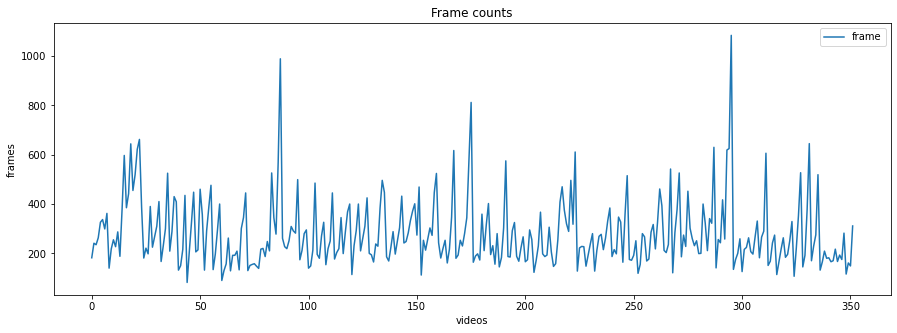

In [8]:
frame_counts.plot(figsize=(15,5))
plt.title("Frame counts")
plt.xlabel('videos')
plt.ylabel('frames')
plt.show()

In [9]:
X = []
y = []
for _, group in df.groupby('filename'):
    x_arr = np.asarray(group[AU_COLS])

    X.append(x_arr)
    
    y_list = group["emotion_1_id"].unique()
    if len(y_list) == 1:
        y.append(y_list[0])
    else:
        raise ValueError('More than 1 label for time series encountered')

In [10]:
y = np.asarray(y)

In [11]:
length = max(map(len, X))

padded_X = []
for xi in X:
    pad = np.zeros((length-len(xi), xi.shape[1]))
    xi = np.concatenate((xi, pad)).T
    padded_X.append(xi)

In [12]:
X = np.array(padded_X)

In [13]:
X.shape

(352, 17, 1084)

In [14]:
y.shape

(352,)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
X_train.shape

(246, 17, 1084)

In [17]:
y_train.shape

(246,)

### Time series exploration

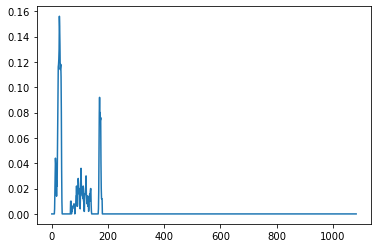

In [24]:
plt.plot(X[0, 0])